PHYS 514 -- Final Project -- Tevfik Can Yüce, 64065

Newton Part

In [1]:
import numpy as np
import newton_functions
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants as constants
import scipy.stats
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize
from scipy.optimize import curve_fit

Part (b):

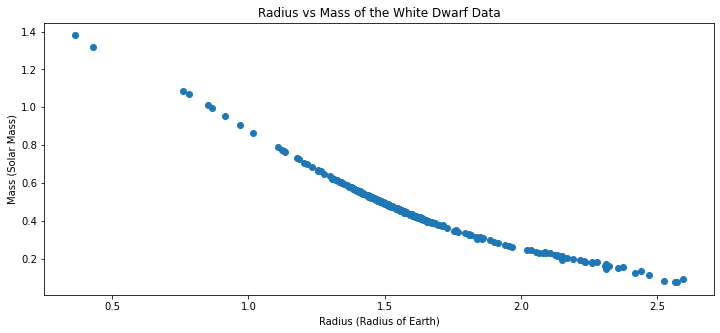

In [2]:
#Reading of the data file in .csv format
filename = 'white_dwarf_data.csv'

#Reading file in format of DataFrame
data_frame = pd.read_csv(filename)

#Convert mass and surface gravity to numpy array
logg_arr = data_frame.loc[:,"logg"].to_numpy()
mass_arr = data_frame.loc[:,"mass"].to_numpy()

#Converting Log Gravity to Radius
solar_mass = 1.98847e30 #kg
earth_radius = 6.3781e6 #m
radius_arr = np.sqrt((constants.gravitational_constant * (mass_arr * solar_mass)) / (0.01 * np.float_power(earth_radius, 2) * np.float_power(10, logg_arr)))

#Plotting the Data
plt.figure(figsize=(12,5))
plt.scatter(x=radius_arr, y=mass_arr)
plt.xlabel('Radius (Radius of Earth)')
plt.ylabel('Mass (Solar Mass)')
plt.title('Radius vs Mass of the White Dwarf Data')
plt.show()

#Scaling of mass and radius to SI units
radius_arr = earth_radius * radius_arr
mass_arr = solar_mass * mass_arr


Part (c):

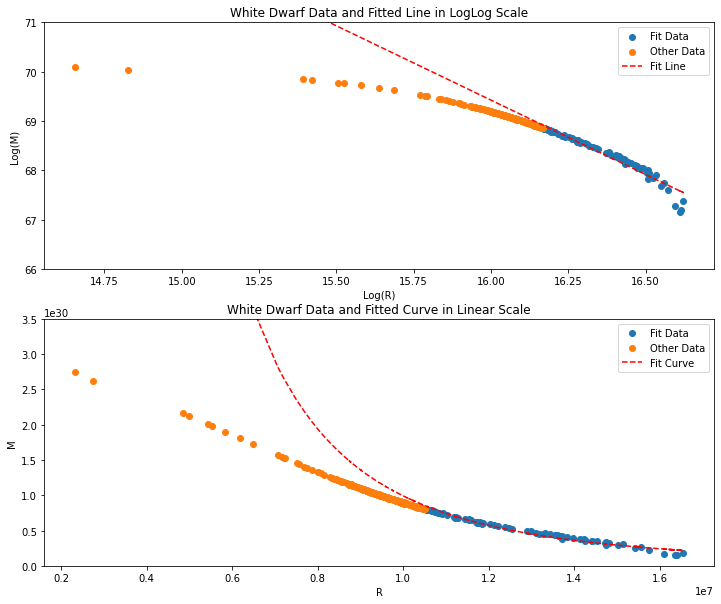

Fitted value of slope is -3.008249321668628


In [3]:
#Parameters
N = 80 #Smallest N stars are considered as low mass

#First sort the arrays w.r.t to mass
#Sorting the arrray
sort_idx = np.argsort(mass_arr)
radius_arr = radius_arr[sort_idx]
mass_arr = mass_arr[sort_idx]

#Fitting Line to Data in Log-Log Scale
regressed_line = scipy.stats.linregress(x=np.log(radius_arr[0:N]), y=np.log(mass_arr[0:N]))

#Plotting Data
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(12,10)

#Plotting in Log Scale
ax[0].scatter(np.log(radius_arr[0:N]), np.log(mass_arr[0:N]))
ax[0].scatter(np.log(radius_arr[N:]), np.log(mass_arr[N:]))
ax[0].plot(np.log(radius_arr), regressed_line.slope * np.log(radius_arr) + regressed_line.intercept, '--', color='red')
ax[0].legend(['Fit Data', 'Other Data', 'Fit Line'])
ax[0].set_ylim([66, 71])
ax[0].set_xlabel('Log(R)')
ax[0].set_ylabel('Log(M)')
ax[0].set_title('White Dwarf Data and Fitted Line in LogLog Scale')

#Plotting in Linear Scale
ax[1].scatter(radius_arr[0:N], mass_arr[0:N])
ax[1].scatter(radius_arr[N:], mass_arr[N:])
ax[1].plot(radius_arr, np.exp(regressed_line.intercept)*np.float_power(radius_arr, regressed_line.slope), '--', color='red')
ax[1].legend(['Fit Data', 'Other Data', 'Fit Curve'])
ax[1].set_ylim([0, 0.35e31])
ax[1].set_title('White Dwarf Data and Fitted Curve in Linear Scale')
ax[1].set_xlabel('R')
ax[1].set_ylabel('M')

plt.show()

#Printing Results
print('Fitted value of slope is ' + str(regressed_line.slope))

d:\ELEC COURSES\PHYS514\Final Project\newton_functions.py:29: RuntimeWarning: invalid value encountered in float_power
  f[1] = -np.float_power(y[0], n) - (2/t) * y[1]


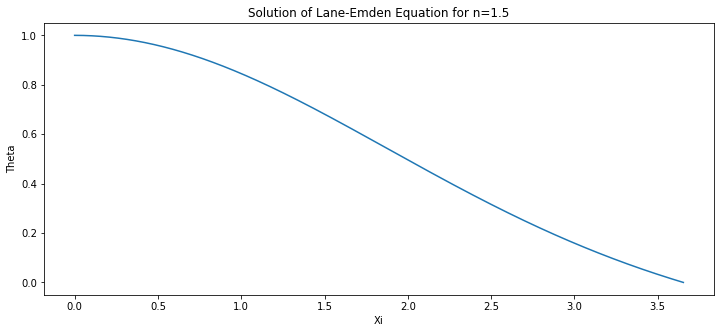

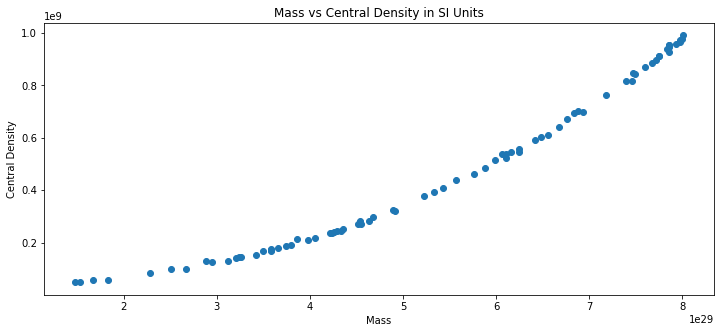

xi_n = 3.6537537362191084
theta prime at xi_n = -0.20330128263854969
K = 2949576.79095954


In [4]:
#This cell calculates K_star and central density

#Finding xi_n, theta_prime at xi_n
n_star = 1.5 #Found and set from knowledge of previous part
xi, theta, theta_prime = newton_functions.lane_emden_solve(n=n_star, xi_f=20)

#Plotting Solution of Lane-Emden Equation
plt.figure(figsize=(12,5))
plt.plot(xi, theta)
plt.xlabel('Xi')
plt.ylabel('Theta')
plt.title('Solution of Lane-Emden Equation for n=1.5')
plt.show()

#Needed values
xi_n = xi[-1]
theta_prime_xi_n = theta_prime[-1]

#Calculate K_star
K_star = (4*np.pi*constants.gravitational_constant/2.5) * np.float_power(np.exp(regressed_line.intercept)/(-4*np.pi*np.float_power(xi_n, 5)*theta_prime_xi_n), 1/3)

#Calculate central density
rho_c_arr_low_mass = (mass_arr[0:N]/(4*np.pi*np.float_power(radius_arr[0:N],3))) * (- xi_n/theta_prime_xi_n)

#Plotting the Data
plt.figure(figsize=(12,5))
plt.scatter(x=mass_arr[0:N], y=rho_c_arr_low_mass)
plt.xlabel('Mass')
plt.ylabel('Central Density')
plt.title('Mass vs Central Density in SI Units')
plt.show()

#Print calculated values
print('xi_n = ' +str(xi_n))
print('theta prime at xi_n = ' + str(theta_prime_xi_n))
print('K = ' + str(K_star))


Part (d):

d:\ELEC COURSES\PHYS514\Final Project\newton_functions.py:53: RuntimeWarning: invalid value encountered in float_power
  x = np.float_power(y[1]/D, 1/q) #Calculate x
d:\ELEC COURSES\PHYS514\Final Project\newton_functions.py:61: RuntimeWarning: invalid value encountered in float_power
  rhs[1] = (1/df_dx)*q*D*np.float_power(y[1]/D, -(1/q)+1) * (-constants.gravitational_constant*y[0]*y[1]/np.float_power(t, 2))


ln(D) = [45.32041309]  Err = 2.688105398527833
ln(D) = [45.32041308]  Err = 2.688105398527524
ln(D) = [45.32038218]  Err = 2.6881053975811486
ln(D) = [45.32038219]  Err = 2.688105397581455
ln(D) = [45.31682769]  Err = 2.6881052884268533
ln(D) = [45.3168277]  Err = 2.6881052884271646
ln(D) = [45.30260973]  Err = 2.688104849219883
ln(D) = [45.30260974]  Err = 2.6881048492201693
ln(D) = [45.2457379]  Err = 2.6881030501634275
ln(D) = [45.24573791]  Err = 2.6881030501637353
ln(D) = [45.01825055]  Err = 2.688095131399809
ln(D) = [45.01825056]  Err = 2.688095131400194
ln(D) = [44.10830118]  Err = 2.688048186678864
ln(D) = [44.10830119]  Err = 2.688048186679557
ln(D) = [40.46850368]  Err = 2.6869837461562827
ln(D) = [40.46850369]  Err = 2.6869837461640507
ln(D) = [25.9093137]  Err = 0.6212066878705423
ln(D) = [25.90931371]  Err = 0.6212066902486252
ln(D) = [10.]  Err = 0.4912758150838937
ln(D) = [10.00000001]  Err = 0.4912758150637146
ln(D) = [20.19010958]  Err = 0.1661722106139284
ln(D) = [20

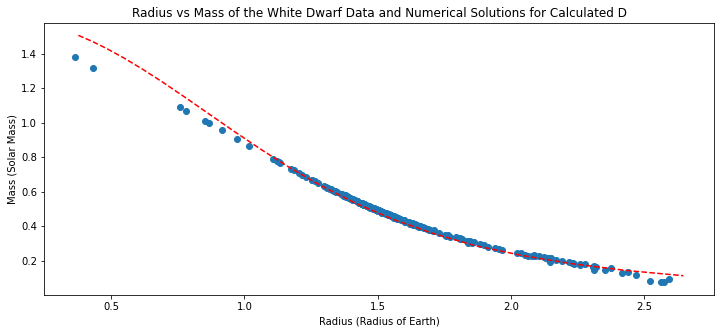

In [5]:
#This cell finds value of D that fits best to Data
N_samples = 20 #Number of IVP solutions for each D guess
q = 3 #Found in previous parts

#First getting initial rho_c value
rho_c_initial = (mass_arr[0]/(4*np.pi*np.float_power(radius_arr[0], 3))) * (-xi_n/theta_prime_xi_n)

#Now have an initial guess of D
small_x = 1e-4
D_initial = rho_c_initial / np.float_power(small_x, 3)

#Finding value of D
D = newton_functions.find_D(radius_arr=radius_arr, mass_arr=mass_arr, rho_c_initial=rho_c_initial, D_initial=D_initial, N_samples=N_samples, q=q, K_star=K_star)

#Calculate value of C with using D
C = (5 * K_star * np.float_power(D, 5/q)) / 8

print('D = ' + str(D))
print('C = ' + str(C))

#Calculate R-M pairs for final values and plot them
R_vals = []
M_vals = []
rho_c_min, rho_c_max = newton_functions.find_central_density_limits(D=D, rho_c_initial=rho_c_initial, n_search_samples=50, min_R=np.min(radius_arr), max_R=np.max(radius_arr), q=q, K_star=K_star)
rho_c_vals = np.logspace(np.log10(rho_c_min), np.log10(rho_c_max), N_samples)
for rho_c in rho_c_vals:
    R,M = newton_functions.calculate_R_M(rho_c=rho_c, D=D, q=q, K_star=K_star)
    R_vals.append(R)
    M_vals.append(M)

R_vals = np.asarray(R_vals).astype(float)
M_vals = np.asarray(M_vals).astype(float)

#Plotting Final values
plt.figure(figsize=(12,5))
plt.scatter(x=radius_arr/earth_radius, y=mass_arr/solar_mass)
plt.plot(R_vals/earth_radius, M_vals/solar_mass, '--', color='red')
plt.xlabel('Radius (Radius of Earth)')
plt.ylabel('Mass (Solar Mass)')
plt.title('Radius vs Mass of the White Dwarf Data and Numerical Solutions for Calculated D')
plt.show()


Part (e):

d:\ELEC COURSES\PHYS514\Final Project\newton_functions.py:53: RuntimeWarning: invalid value encountered in float_power
  x = np.float_power(y[1]/D, 1/q) #Calculate x
d:\ELEC COURSES\PHYS514\Final Project\newton_functions.py:61: RuntimeWarning: invalid value encountered in float_power
  rhs[1] = (1/df_dx)*q*D*np.float_power(y[1]/D, -(1/q)+1) * (-constants.gravitational_constant*y[0]*y[1]/np.float_power(t, 2))


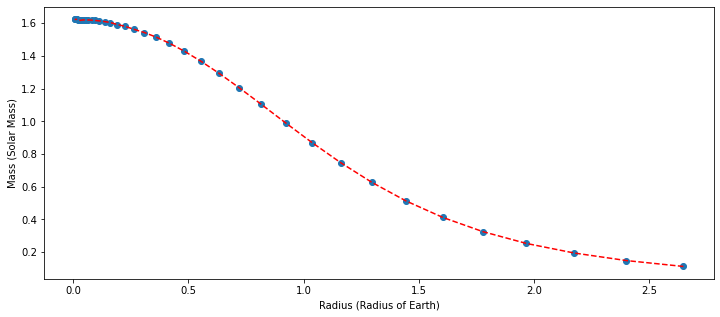

Computational Chandrasekhar Mass (Solar Mass) = 1.6232019231238535
xi_3 = 6.896890404199924
theta_prime_xi_3 = -0.042429243484483965
Theoretical value of Chandrasekhar mass = 1.4562535166876054 Solar Masses


In [6]:
#This cell calculates M-R for broad range of rho_c values to find Chandresekhar Mass
n_points = 40 #Number of rho_c points to be used
rho_c_vals = rho_c_initial * np.logspace(0.15, 10, n_points) #Central density values to be used

#Calculate R-M values for selected central density values
R_vals = []
M_vals = []
for rho_c in rho_c_vals:
    R,M = newton_functions.calculate_R_M(rho_c=rho_c, D=D, q=q, K_star=K_star)
    R_vals.append(R)
    M_vals.append(M)

R_vals = np.asarray(R_vals).astype(float)
M_vals = np.asarray(M_vals).astype(float)

#Plotting the values
plt.figure(figsize=(12,5))
plt.scatter(x=R_vals/earth_radius, y=M_vals/solar_mass)
plt.plot(R_vals/earth_radius, M_vals/solar_mass, '--', color='red')
plt.xlabel('Radius (Radius of Earth)')
plt.ylabel('Mass (Solar Mass)')
plt.show()

print('Computational Chandrasekhar Mass (Solar Mass) = ' + str(M_vals[-1]/solar_mass))

#Solving Lane-Emden Equation for n=3
xi, theta, theta_prime = newton_functions.lane_emden_solve(n=3, xi_f=10)

#Finding Intersection Point
xi_3_idx = np.abs(theta).argmin()
xi_3 = xi[xi_3_idx]
theta_prime_xi_3 = theta_prime[xi_3_idx]

print('xi_3 = ' + str(xi_3))
print('theta_prime_xi_3 = ' + str(theta_prime_xi_3))

#Calculating final Chandrasekhar Mass
C_theoretical = 6.002332185660436e21
D_theoretical = 1947864333.345182
K_CH = 2*C_theoretical*np.float_power(D_theoretical, -4/3)

M_CH = -4*np.pi*np.float_power(np.pi * constants.gravitational_constant / K_CH, -3/2) * np.float_power(xi_3, 2) * theta_prime_xi_3

print('Theoretical value of Chandrasekhar mass = ' + str(M_CH/solar_mass) + ' Solar Masses')